<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


# Part 8: SpaceX Launches - Model Selection and Evaluation

**Short description:**  
This notebook performs model selection and evaluation for launch-landing classification. It standardizes features, splits data into train/test sets, runs grid-search cross-validation to tune hyperparameters for Logistic Regression, SVM, Decision Tree and KNN, displays confusion matrices and compares final test accuracies.

**Objectives**
- Load SpaceX feature and label datasets.
- Standardize features using `StandardScaler`.
- Use `GridSearchCV` (10-fold CV) to find hyperparameters for Logistic Regression, SVM, Decision Tree and KNN.
- Evaluate each tuned model on the test set and display confusion matrices.
- Compare model performance via a bar chart of test accuracies.

**Notice about documentation:**  
The original notebook submission (course assignment) was kept intact. I have **only modified documentation (comments, headings, markdown)** and made **minimal, necessary corrections** to ensure the notebook runs without errors. All rights related to the lab/workshop design and original exercise belong exclusively to **IBM Corporation**. This notebook includes additional documentation for clarity, but the intellectual property of the original exercise is retained by IBM.

---

## Table of contents

1. Dependencies & execution instructions  
2. Helper: confusion matrix plot function  
3. Load data (feature CSV and dataset CSV)  
4. Preprocessing: scaling and train/test split  
5. Logistic Regression (GridSearchCV)  
6. SVM (GridSearchCV)  
7. Decision Tree (GridSearchCV)  
8. KNN (GridSearchCV)  
9. Compare models and visualize results  
10. Notes & reproducibility


## 1) Dependencies & execution instructions

This section installs and imports required Python packages.  

**Recommended local execution steps:**

1. Create and activate a Python virtual environment:
   - `python -m venv venv`
   - `source venv/bin/activate` (macOS / Linux) or `venv\Scripts\activate` (Windows)
2. Install dependencies:
   - `pip install -r requirements.txt`
3. Launch Jupyter Notebook:
   - `jupyter notebook`
4. Open this notebook and run cells top-to-bottom.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## 2) Helper: confusion matrix plotting function

This helper uses seaborn to plot confusion matrices for model predictions.


In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## 3) Load data (features & labels)

Load `dataset_part_2.csv` (for `data`) and `dataset_part_3.csv` (for features X) from the course URLs. Inspect the top rows as needed.

In [3]:
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
data = pd.read_csv(URL1)
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [4]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
X = pd.read_csv(URL2)
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [5]:
Y = data['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

## 4) Preprocessing: scaling and train/test split

Standardize features with `StandardScaler` and split into training and test sets (80/20, `random_state=2`).

In [6]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=2)

In [8]:
Y_test.shape

(18,)

## 5) Logistic Regression (GridSearchCV)

Run grid search over `C` and `penalty/solver` with 10-fold CV, print best hyperparameters and CV accuracy, evaluate on the test set, show confusion matrix.

In [9]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [10]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv=GridSearchCV(estimator=lr,param_grid=parameters,cv=10).fit(X_train,Y_train)



Best parameters and accuracy on the validation data:

In [11]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


Accuracy on the test data:


In [12]:
logreg_score=logreg_cv.score(X_test,Y_test)
logreg_score

0.8333333333333334

Confusion matrix:

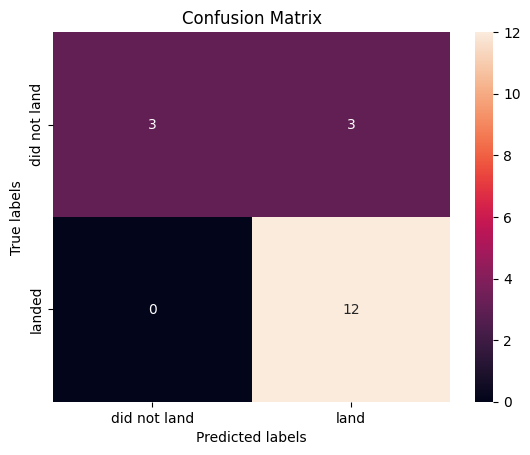

In [13]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## 6) SVM (GridSearchCV)

Run grid search for SVM kernels, `C` and `gamma` ranges with 10-fold CV, print best hyperparameters and CV accuracy, evaluate on the test set, show confusion matrix.

In [14]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [15]:
svm_cv = GridSearchCV(estimator=svm,param_grid=parameters,cv=10).fit(X_train,Y_train)

Best parameters and accuracy on the validation data:

In [16]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


Accuracy on the test data:

In [17]:
svm_score = svm_cv.score(X_test,Y_test)
svm_score

0.8333333333333334

Confusion matrix:

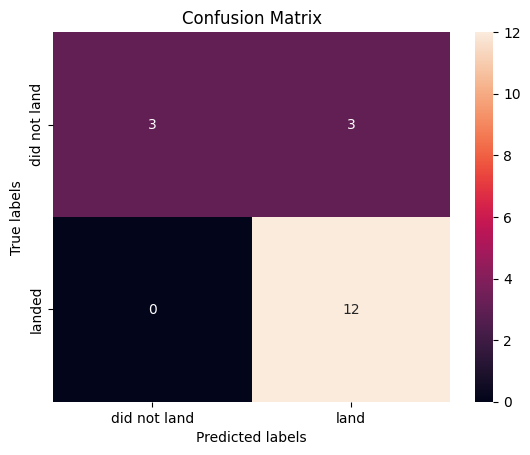

In [18]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## 7) Decision Tree (GridSearchCV)
Run grid search for various tree hyperparameters (`criterion`, `max_depth`, `max_features`, etc.) with 10-fold CV, print best hyperparameters and CV accuracy, evaluate on the test set, show confusion matrix.

In [19]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [20]:
tree_cv = GridSearchCV(estimator=tree,param_grid=parameters,cv=10).fit(X_train,Y_train)

c:\Users\aleje\OneDrive - Universidad EAFIT\Escritorio\Alejandro\Academia\Portfolio\IBM Data Science Professional Certificate\10_Applied Data Science Capstone\8_Predictive Analysis\venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aleje\OneDrive - Universidad EAFIT\Escritorio\Alejandro\Academia\Portfolio\IBM Data Science Professional Certificate\10_Applied Data Science Capstone\8_Predictive Analysis\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_tra

Best parameters and accuracy on the validation data:

In [21]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.8625


Accuracy on the test data:

In [22]:
tree_score = tree_cv.score(X_test,Y_test)
tree_score

0.8888888888888888

Confusion matrix:

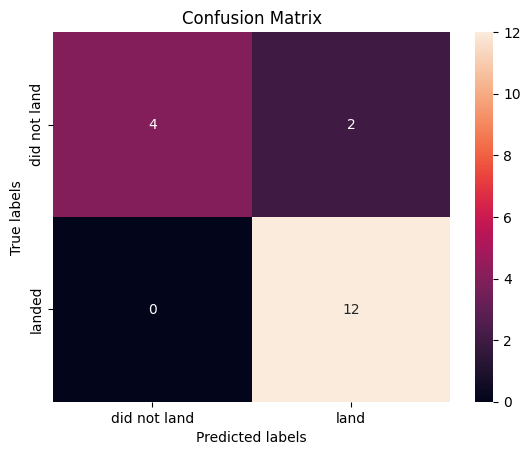

In [23]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## 8) KNN (GridSearchCV)
Run grid search across `n_neighbors`, `algorithm`, and `p` with 10-fold CV, print best hyperparameters and CV accuracy, evaluate on the test set, show confusion matrix.

In [24]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [25]:
knn_cv = GridSearchCV(estimator=KNN,param_grid=parameters,cv=10).fit(X_train,Y_train)

Best parameters and accuracy on the validation data:

In [26]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


Accuracy on the test data:

In [27]:
knn_score = knn_cv.score(X_test,Y_test)
knn_score

0.8333333333333334

Confusion matrix:

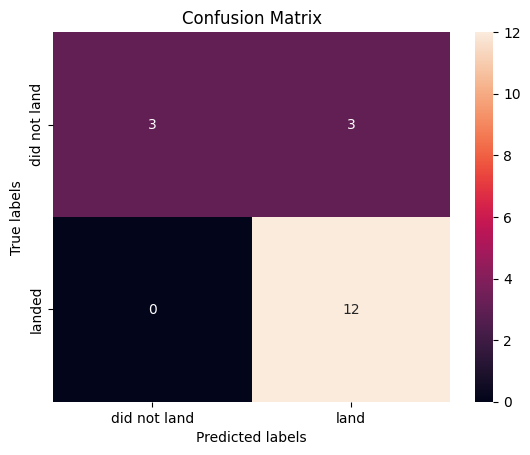

In [28]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## 9) Compare models and visualize results

Collect test accuracies and plot a bar chart comparing model performances.

In [29]:
best_scores = [logreg_score,svm_score,tree_score,knn_score]
method = ['Logistic Regression','SVM','Decision Tree','KNN']
models = pd.DataFrame({'Method':method,'Accuracy':best_scores})
models.sort_values(by='Accuracy',ascending=False,ignore_index=True)

,Method,Accuracy
0,Decision Tree,0.888889
1,Logistic Regression,0.833333
2,SVM,0.833333
3,KNN,0.833333


<function matplotlib.pyplot.show(close=None, block=None)>

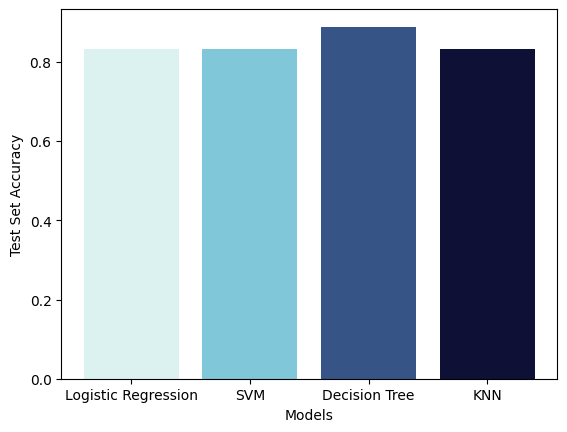

In [30]:
plt.bar(x=models['Method'],height=models['Accuracy'],color=['#DCF2F1','#7FC7D9','#365486','#0F1035'])
plt.xlabel('Models')
plt.ylabel('Test Set Accuracy')
plt.show

## 10) Notes & reproducibility

- The notebook uses course-hosted CSV URLs — if offline, download the CSVs and update the paths.
- GridSearchCV with many parameter combinations and 10-fold CV can be computationally intensive; consider reducing parameter grids or CV folds for faster iteration.

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
